In [238]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [239]:
# 数据说明非常的简略，只说明了类别特征和数值特征，且大多数都做了脱敏处理，因此把名字分别改为Numerical和Catrgorical
train = pd.read_excel('./inputs/train.xlsx')
test =  pd.read_excel('inputs/test_b.xlsx')
submission = pd.read_fwf('inputs/sample_submit.txt')
df = pd.read_excel('inputs/feature_explain.xlsx', sheet_name='train', skiprows=2)
index_num = 0
index_category = 0
for va in df.values:
    if va[1]=='Categorical':
        train=train.rename(columns={va[0]:va[1]+"_"+str(index_category)})
        test=test.rename(columns={va[0]:va[1]+"_"+str(index_category)})
        index_category+=1
    else:
        train=train.rename(columns={va[0]:va[1]+"_"+str(index_num)})
        test=test.rename(columns={va[0]:va[1]+"_"+str(index_num)})
        index_num+=1
# 把category和numerical 分开放
train=train[['CUST_UID','LABEL','Categorical_0','Categorical_1','Categorical_2','Categorical_3','Categorical_4','Categorical_5','Numerical_0','Numerical_1','Numerical_2','Numerical_3','Numerical_4','Numerical_5','Numerical_6','Numerical_7','Numerical_8','Numerical_9','Numerical_10','Numerical_11','Numerical_12','Numerical_13','Numerical_14','Numerical_15','Numerical_16','Numerical_17','Numerical_18','Numerical_19','Numerical_20','Numerical_21','Numerical_22','Numerical_23','Numerical_24','Numerical_25','Numerical_26','Numerical_27','Numerical_28','Numerical_29','Numerical_30','Numerical_31','Numerical_32','Numerical_33','Numerical_34','Numerical_35','Numerical_36','Numerical_37','Numerical_38','Numerical_39','Numerical_40','Numerical_41','Numerical_42']]
test=test[['CUST_UID','Categorical_0','Categorical_1','Categorical_2','Categorical_3','Categorical_4','Categorical_5','Numerical_0','Numerical_1','Numerical_2','Numerical_3','Numerical_4','Numerical_5','Numerical_6','Numerical_7','Numerical_8','Numerical_9','Numerical_10','Numerical_11','Numerical_12','Numerical_13','Numerical_14','Numerical_15','Numerical_16','Numerical_17','Numerical_18','Numerical_19','Numerical_20','Numerical_21','Numerical_22','Numerical_23','Numerical_24','Numerical_25','Numerical_26','Numerical_27','Numerical_28','Numerical_29','Numerical_30','Numerical_31','Numerical_32','Numerical_33','Numerical_34','Numerical_35','Numerical_36','Numerical_37','Numerical_38','Numerical_39','Numerical_40','Numerical_41','Numerical_42']]

In [240]:
# 缺失值超过一定比例的直接扔掉
features = train.columns.tolist()
for f in features:
    if train[f].isnull().sum()/train.shape[0]>0.3:
        train.drop(columns=[f],inplace=True)
        test.drop(columns=[f],inplace=True)

In [241]:
# 字典编码
def change_object_cols(se):
    value = se.unique().tolist()
    value.sort
    return se.map(pd.Series(range(len(value)), index=value)).values

In [242]:
df = pd.concat([train.assign(is_train = 1),test.assign(is_train = 0)],ignore_index=True)
features = df.columns.tolist()[2:6]
for f in features:
    df[f] = change_object_cols(df[f].fillna("ety"))

In [243]:
# 把train 和 test放到一起，方便进行后续处理
train_label=df[df['is_train']==1]['LABEL']
df.drop('LABEL',axis=1,inplace=True)

In [244]:
# 数值的缺失值填中位数
for f in df.columns.tolist():
    if df[f].dtype=='float64':
        df[f].fillna(df[f].median(),inplace=True)

In [245]:
# Normalization
features = df.columns.tolist()
numerical_features = features[5:43]
df[numerical_features]=(df[numerical_features]-df[numerical_features].mean())/df[numerical_features].std(ddof=0)
for f in numerical_features:
    df.loc[df[f]>3,f]=3
    df.loc[df[f]<-3,f]=-3

C:\Users\quanyu\AppData\Local\Temp/ipykernel_6896/863546662.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['LABEL'] = train_label


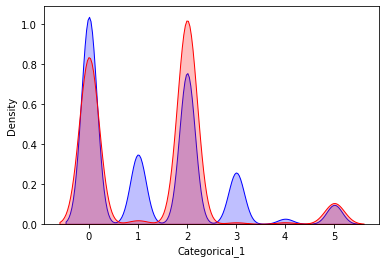

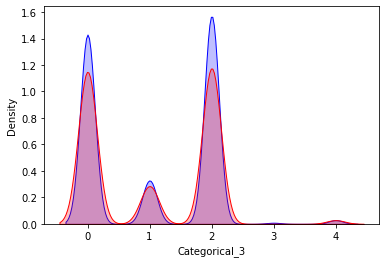

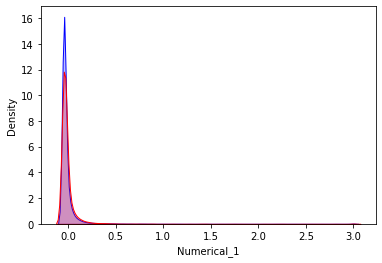

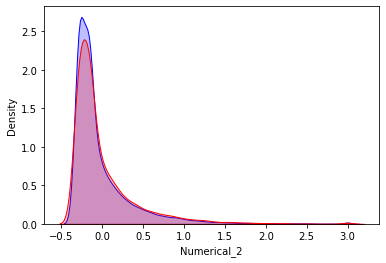

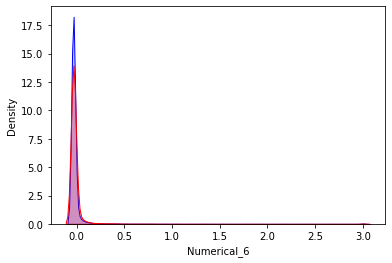

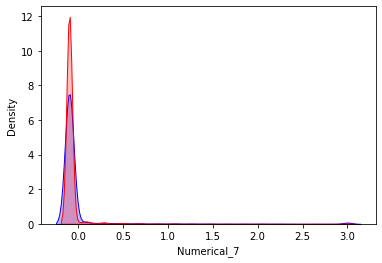

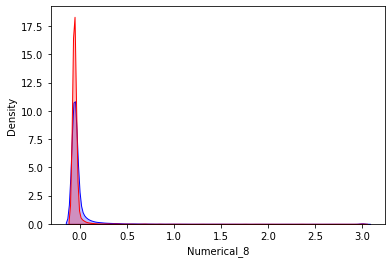

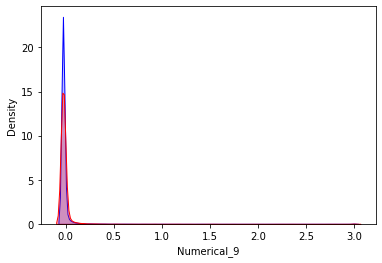

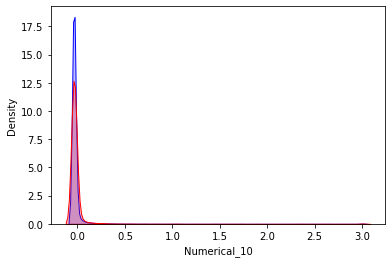

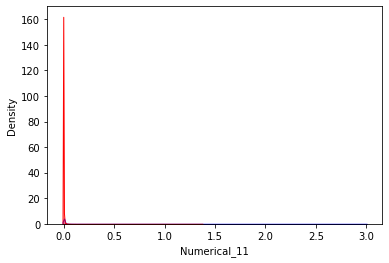

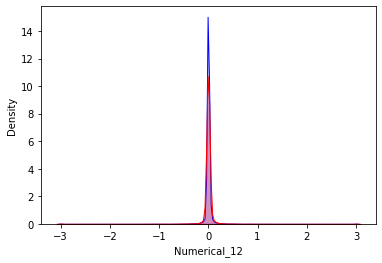

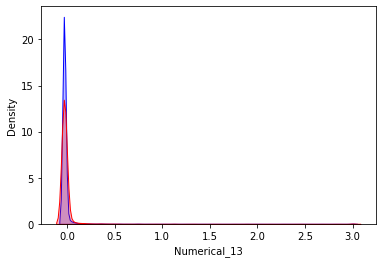

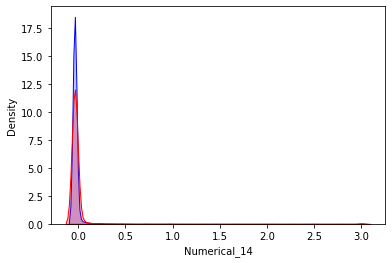

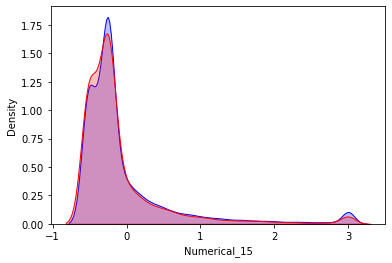

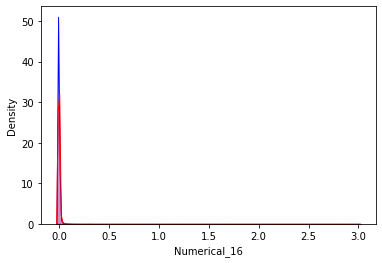

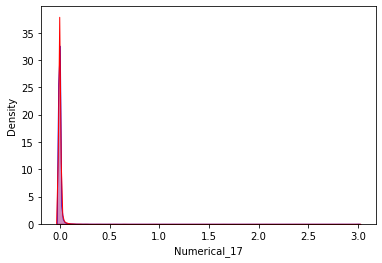

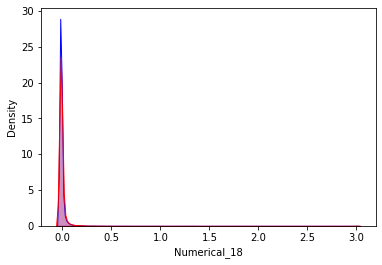

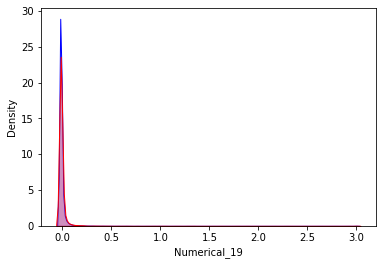

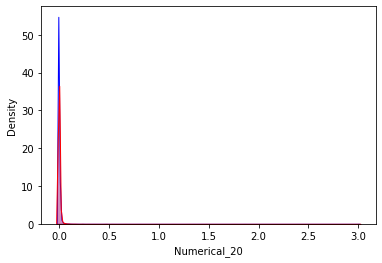

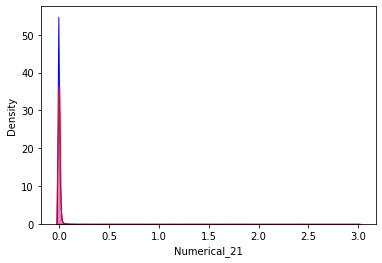

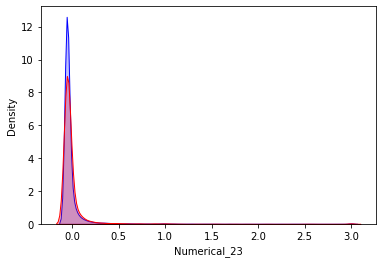

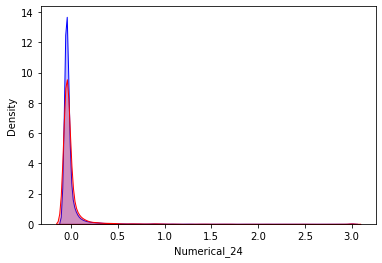

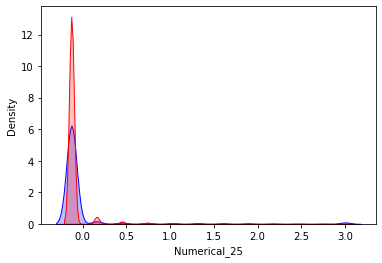

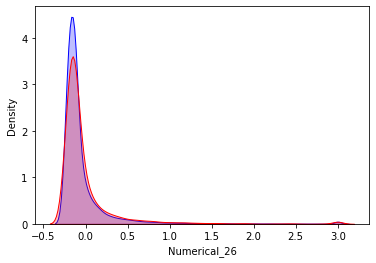

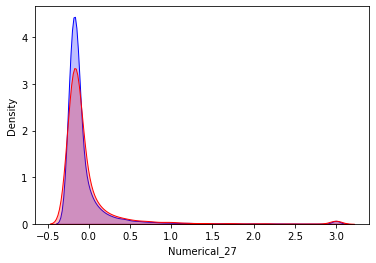

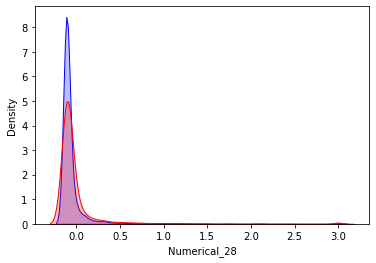

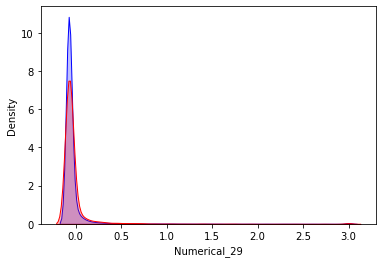

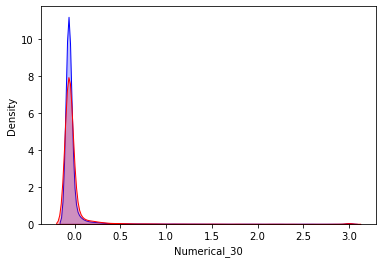

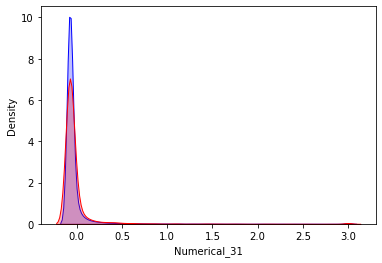

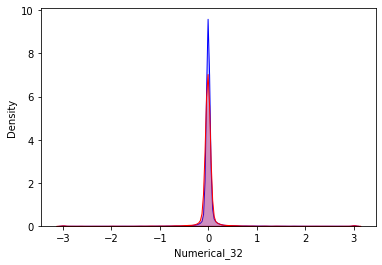

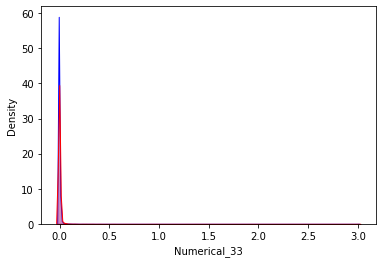

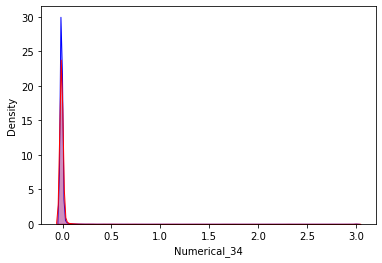

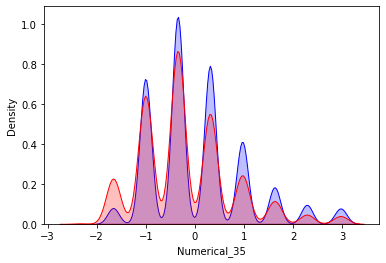

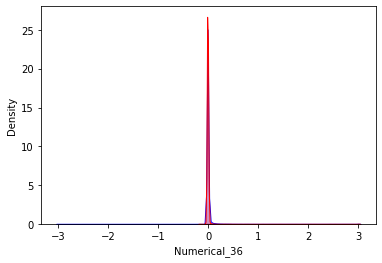

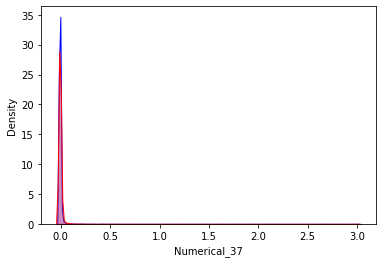

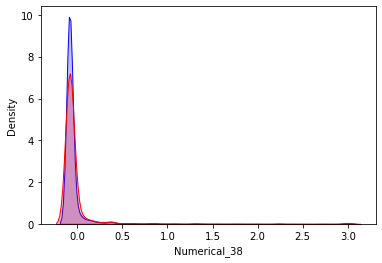

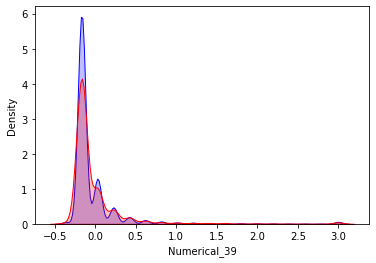

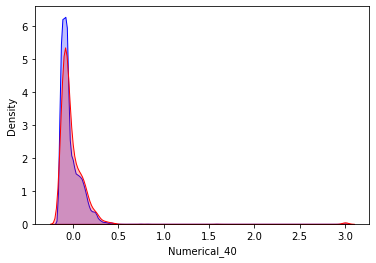

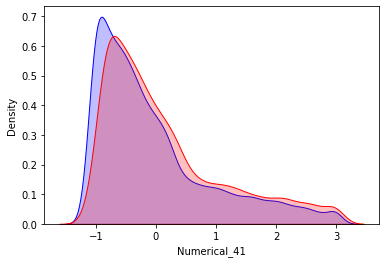

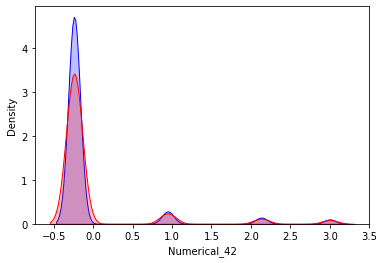

In [246]:
train_df = df[df['is_train']==1]
train_df['LABEL'] = train_label
test_df = df[df['is_train']==0]
for f in train.columns.tolist():
    if train[f].dtype=='float64':
# 绘KDE对比分布
        sns.kdeplot(train_df[f], shade = True, color='b', label = 'train')
        sns.kdeplot(test_df[f], shade = True, color='r', label = 'test')
        plt.xlabel(f)
        plt.show()

In [247]:
#df.to_csv("./clean/Adversary.csv",index=False)

#### 因为train和test的分布有很大的不同，因此采用对抗验证
#### 训练模型， 对train set的每行数据进行测试集的概率预测，将更可能是test的数据集赋予更高的权重

In [248]:

from sklearn.model_selection import KFold
from hyperopt import hp, fmin, tpe
from numpy.random import RandomState
from sklearn.metrics import roc_auc_score
import lightgbm as lgb

In [264]:
def params_append(params):
    params['objective'] = 'binary'
    params['metric'] = 'binary_logloss'
    params['bagging_seed'] = 2022
    params['feature_pre_filter'] = False
    return params

In [250]:
df

,CUST_UID,Categorical_1,Categorical_2,Categorical_3,Categorical_5,Numerical_1,Numerical_2,Numerical_6,Numerical_7,Numerical_8,...,Numerical_34,Numerical_35,Numerical_36,Numerical_37,Numerical_38,Numerical_39,Numerical_40,Numerical_41,Numerical_42,is_train
0,2a171d461bf24a739b804c2843ad4f6e,0,0,0,0,-0.045182,0.084752,-0.035609,-0.099398,-0.057931,...,-0.017007,-1.008688,-0.017337,-0.012061,-0.036332,-0.168461,0.046618,-0.463146,-0.239927,1
1,c58d5848d18548e297963c2d9e092699,0,0,0,1,-0.031109,-0.152697,-0.036633,-0.099398,-0.062794,...,-0.017917,2.275953,-0.017669,-0.009889,-0.092103,0.028110,-0.133442,-0.830797,-0.239927,1
2,74e6d8179e784a039bcb5a722014f4a4,0,0,1,0,-0.051750,-0.152697,-0.037990,-0.099398,-0.063947,...,-0.018382,-0.351760,-0.017747,-0.012061,-0.087670,-0.168461,-0.021741,0.710103,-0.239927,1
3,1b6a8be2c2e34de09ca00d71470ec180,1,1,2,2,-0.042368,-0.303582,-0.036921,-0.099398,-0.063947,...,-0.018433,-1.008688,-0.017698,-0.012061,-0.092313,-0.168461,-0.145490,-1.003616,-0.239927,1
4,1974b5e0440a41128a416a8cdc8a7c16,2,1,1,2,-0.042368,-0.152697,-0.036921,-0.099398,-0.063947,...,-0.018185,-1.665616,-0.017853,-0.012061,-0.087670,-0.168461,-0.070355,-0.564588,-0.239927,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51995,01d799cc3246416387f2ff9a1468ede1,0,1,0,4,-0.042368,0.197122,-0.036921,-0.099398,-0.063947,...,-0.018355,-0.351760,-0.017660,-0.007717,0.298142,1.010961,-0.008962,0.202909,-0.239927,0
51996,55dba67ea8eb464a810c4fea9331e443,2,1,1,5,-0.042368,-0.293953,-0.036921,-0.099398,-0.063947,...,-0.017365,-1.665616,-0.017853,-0.012061,-0.087670,-0.365031,-0.070355,0.290392,3.000000,0
51997,527e025840b14373890844a1138197ab,5,1,2,2,-0.042368,-0.271518,-0.036921,-0.099398,-0.063947,...,0.004076,-1.008688,-0.017840,-0.012061,-0.069001,-0.168461,-0.038216,-0.819516,-0.239927,0
51998,89a4e87c9a764c6c9eafda790c76a4e6,0,0,0,2,-0.050812,-0.248986,-0.034035,-0.099398,-0.063947,...,-0.016283,-0.351760,-0.017758,-0.012061,-0.080669,-0.168461,-0.094258,-0.791614,-0.239927,0


In [257]:
def param_hyperopt(train):
    label = 'is_train'
    features = train.columns.tolist()
    features.remove('CUST_UID')
    features.remove('is_train')
    train_data = lgb.Dataset(train[features], train[label], silent=True)
    def hyperopt_objective(params):
        """

        :param params:
        :return:
        """
        params = params_append(params)
        print(params)
        res = lgb.cv(params, train_data, 1000,
                     nfold=3,
                     stratified=False,
                     shuffle=True,
                     metrics='binary_logloss',
                     early_stopping_rounds=30,
                     verbose_eval=True,
                     show_stdv=False,
                     seed=2022)
        return min(res['binary_logloss-mean'])

    params_space = {
        'learning_rate': hp.uniform('learning_rate', 1e-3, 5e-1),
        'bagging_fraction': hp.uniform('bagging_fraction', 0.5, 1),
        'feature_fraction': hp.uniform('feature_fraction', 0.5, 1),
        'num_leaves': hp.choice('num_leaves', list(range(10, 300, 10))),
        'reg_alpha': hp.randint('reg_alpha', 0, 10),
        'reg_lambda': hp.uniform('reg_lambda', 0, 10),
        'bagging_freq': hp.randint('bagging_freq', 1, 10),
        'min_child_samples': hp.choice('min_child_samples', list(range(1, 30, 5))),
        'max_drop': hp.randint('max_drop',50,200)
    }
    params_best = fmin(
        hyperopt_objective,
        space=params_space,
        algo=tpe.suggest,
        max_evals=30,
        rstate=np.random.default_rng(2022))
    return params_best


In [261]:
# best_clf = param_hyperopt(df)
best_clf={'bagging_fraction': 0.9979352817983933,
 'bagging_freq': 8,
 'feature_fraction': 0.5857626024375278,
 'learning_rate': 0.34863103076079405,
 'max_drop': 50,
 'min_child_samples': 1,
 'num_leaves': 15,
 'reg_alpha': 3,
 'reg_lambda': 7.576883737064452,
 'objective': 'binary',
 'metric': 'auc',
 'bagging_seed': 2022,
 'feature_pre_filter': False}


In [265]:
label = 'is_train'
features = df.columns.tolist()
features.remove('CUST_UID')
features.remove('is_train')
category_features=['Categorical_1','Categorical_2','Categorical_3','Categorical_5']
params = params_append(best_clf)
kf = KFold(n_splits=10, random_state=2022, shuffle=True)
prediction_test = 0
cv_score = []
prediction_train = pd.Series()
ESR = 30
NBR = 1000
VBE = 30
for train_part_index, eval_index in kf.split(df[features], df[label]):
    # 模型训练
    train_part = lgb.Dataset(df[features].loc[train_part_index],
                             df[label].loc[train_part_index], feature_name=features, categorical_feature=category_features)
    eval = lgb.Dataset(df[features].loc[eval_index],
                       df[label].loc[eval_index], feature_name=features, categorical_feature=category_features)
    bst = lgb.train(params, train_part, num_boost_round=NBR,
                    valid_sets=[train_part, eval],
                    valid_names=['train', 'valid'],
                    early_stopping_rounds=ESR, verbose_eval=VBE)
    prediction_train = prediction_train.append(pd.Series(bst.predict(df[features].loc[eval_index]),
                                                         index=eval_index))
    eval_pre = bst.predict(df[features].loc[eval_index])
    score = roc_auc_score(df[label].loc[eval_index].values, eval_pre)
    cv_score.append(score)
print(cv_score, sum(cv_score) / 10)

C:\Users\quanyu\AppData\Local\Temp/ipykernel_6896/1875412772.py:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prediction_train = pd.Series()
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()'

[LightGBM] [Info] Number of positive: 36031, number of negative: 10769
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005952 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8195
[LightGBM] [Info] Number of data points in the train set: 46800, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.769893 -> initscore=1.207708
[LightGBM] [Info] Start training from score 1.207708
Training until validation scores don't improve for 30 rounds
[30]	train's binary_logloss: 0.154929	valid's binary_logloss: 0.163952


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[60]	train's binary_logloss: 0.121055	valid's binary_logloss: 0.136517
[90]	train's binary_logloss: 0.102695	valid's binary_logloss: 0.125535
[120]	train's binary_logloss: 0.0911458	valid's binary_logloss: 0.118925
[150]	train's binary_logloss: 0.0805568	valid's binary_logloss: 0.112773
[180]	train's binary_logloss: 0.0731596	valid's binary_logloss: 0.110143
[210]	train's binary_logloss: 0.0660878	valid's binary_logloss: 0.107505
[240]	train's binary_logloss: 0.0598115	valid's binary_logloss: 0.104118
[270]	train's binary_logloss: 0.054947	valid's binary_logloss: 0.101007
[300]	train's binary_logloss: 0.0511936	valid's binary_logloss: 0.100037
[330]	train's binary_logloss: 0.0475588	valid's binary_logloss: 0.0985931
[360]	train's binary_logloss: 0.0446019	valid's binary_logloss: 0.0985469
[390]	train's binary_logloss: 0.0410625	valid's binary_logloss: 0.0969025
[420]	train's binary_logloss: 0.0379963	valid's binary_logloss: 0.0956724
[450]	train's binary_logloss: 0.0359128	valid's bina

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Ref

[LightGBM] [Info] Number of positive: 35957, number of negative: 10843
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008108 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8195
[LightGBM] [Info] Number of data points in the train set: 46800, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.768312 -> initscore=1.198804
[LightGBM] [Info] Start training from score 1.198804
Training until validation scores don't improve for 30 rounds
[30]	train's binary_logloss: 0.15643	valid's binary_logloss: 0.162909
[60]	train's binary_logloss: 0.122073	valid's binary_logloss: 0.138034
[90]	train's binary_logloss: 0.104228	valid's binary_logloss: 0.126713
[120]	train's binary_logloss: 0.0909802	valid's binary_logloss: 0.120096
[150]	train's binary_logloss: 0.0788059	valid's binary_logloss: 0.111412
[180]	train's binary_l

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Ref

[LightGBM] [Info] Number of positive: 36000, number of negative: 10800
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006732 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8193
[LightGBM] [Info] Number of data points in the train set: 46800, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.769231 -> initscore=1.203973
[LightGBM] [Info] Start training from score 1.203973
Training until validation scores don't improve for 30 rounds
[30]	train's binary_logloss: 0.156748	valid's binary_logloss: 0.156746
[60]	train's binary_logloss: 0.124942	valid's binary_logloss: 0.133515
[90]	train's binary_logloss: 0.105551	valid's binary_logloss: 0.120237
[120]	train's binary_logloss: 0.0924118	valid's binary_logloss: 0.113237
[150]	train's binary_logloss: 0.0826273	valid's binary_logloss: 0.107522
[180]	train's binary_logloss: 0.0733614	valid's binary_logloss: 0.103066
[210]	train'

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Ref

[LightGBM] [Info] Number of positive: 36023, number of negative: 10777
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003702 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8194
[LightGBM] [Info] Number of data points in the train set: 46800, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.769722 -> initscore=1.206743
[LightGBM] [Info] Start training from score 1.206743
Training until validation scores don't improve for 30 rounds
[30]	train's binary_logloss: 0.158505	valid's binary_logloss: 0.167089
[60]	train's binary_logloss: 0.123823	valid's binary_logloss: 0.139689
[90]	train's binary_logloss: 0.106746	valid's binary_logloss: 0.128763
[120]	train's binary_logloss: 0.0931213	valid's binary_logloss: 0.121456
[150]	train's binary_logloss: 0.0826769	valid's binary_logloss: 0.115364
[180]	train's binary_logloss: 0.0737754	valid's binary_logloss: 0.109367
[210]	train'

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Ref

[LightGBM] [Info] Number of positive: 36023, number of negative: 10777
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8194
[LightGBM] [Info] Number of data points in the train set: 46800, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.769722 -> initscore=1.206743
[LightGBM] [Info] Start training from score 1.206743
Training until validation scores don't improve for 30 rounds
[30]	train's binary_logloss: 0.152048	valid's binary_logloss: 0.165877
[60]	train's binary_logloss: 0.120285	valid's binary_logloss: 0.140359
[90]	train's binary_logloss: 0.103776	valid's binary_logloss: 0.130137
[120]	train's binary_logloss: 0.0891136	valid's binary_logloss: 0.122704
[150]	train's binary_logloss: 0.078455	valid's binary_logloss: 0.116602
[180]	train's binary_logloss: 0.0713381	valid's binary_logloss: 0.113446
[210]	train's

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Ref

[LightGBM] [Info] Number of positive: 36011, number of negative: 10789
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003835 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8194
[LightGBM] [Info] Number of data points in the train set: 46800, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.769466 -> initscore=1.205297
[LightGBM] [Info] Start training from score 1.205297
Training until validation scores don't improve for 30 rounds
[30]	train's binary_logloss: 0.154551	valid's binary_logloss: 0.172869
[60]	train's binary_logloss: 0.121884	valid's binary_logloss: 0.14925
[90]	train's binary_logloss: 0.104032	valid's binary_logloss: 0.138465
[120]	train's binary_logloss: 0.0878215	valid's binary_logloss: 0.125733
[150]	train's binary_logloss: 0.0795123	valid's binary_logloss: 0.122592
[180]	train's binary_logloss: 0.0695419	valid's binary_logloss: 0.115826
[210]	train's

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Ref

[LightGBM] [Info] Number of positive: 35973, number of negative: 10827
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8195
[LightGBM] [Info] Number of data points in the train set: 46800, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.768654 -> initscore=1.200726
[LightGBM] [Info] Start training from score 1.200726
Training until validation scores don't improve for 30 rounds
[30]	train's binary_logloss: 0.155661	valid's binary_logloss: 0.163892
[60]	train's binary_logloss: 0.122092	valid's binary_logloss: 0.136046
[90]	train's binary_logloss: 0.104314	valid's binary_logloss: 0.124663
[120]	train's binary_logloss: 0.0920099	valid's binary_logloss: 0.118188
[150]	train's binary_logloss: 0.0823238	valid's binary_logloss: 0.113635
[180]	train's binary_logloss: 0.0749226	valid's binary_logloss: 0.111506
[210]	train'

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Ref

[LightGBM] [Info] Number of positive: 35980, number of negative: 10820
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004821 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8195
[LightGBM] [Info] Number of data points in the train set: 46800, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.768803 -> initscore=1.201567
[LightGBM] [Info] Start training from score 1.201567
Training until validation scores don't improve for 30 rounds
[30]	train's binary_logloss: 0.152016	valid's binary_logloss: 0.168043
[60]	train's binary_logloss: 0.120025	valid's binary_logloss: 0.144056
[90]	train's binary_logloss: 0.104098	valid's binary_logloss: 0.135371
[120]	train's binary_logloss: 0.0915789	valid's binary_logloss: 0.128243
[150]	train's binary_logloss: 0.0774709	valid's binary_logloss: 0.115669
[180]	train's binary_logloss: 0.0692897	valid's binary_logloss: 0.110014
[210]	train'

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Ref

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006496 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8195
[LightGBM] [Info] Number of data points in the train set: 46800, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.769402 -> initscore=1.204936
[LightGBM] [Info] Start training from score 1.204936
Training until validation scores don't improve for 30 rounds
[30]	train's binary_logloss: 0.153655	valid's binary_logloss: 0.171759
[60]	train's binary_logloss: 0.11977	valid's binary_logloss: 0.14715
[90]	train's binary_logloss: 0.102086	valid's binary_logloss: 0.137049
[120]	train's binary_logloss: 0.0875152	valid's binary_logloss: 0.127683
[150]	train's binary_logloss: 0.0779541	valid's binary_logloss: 0.122284
[180]	train's binary_logloss: 0.0695723	valid's binary_logloss: 0.117435
[210]	train's binary_logloss: 0.0627245	valid's binary_logloss: 0.114356
[240]	train'

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Ref

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8194
[LightGBM] [Info] Number of data points in the train set: 46800, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.769103 -> initscore=1.203251
[LightGBM] [Info] Start training from score 1.203251
Training until validation scores don't improve for 30 rounds
[30]	train's binary_logloss: 0.15521	valid's binary_logloss: 0.166629
[60]	train's binary_logloss: 0.120718	valid's binary_logloss: 0.141536
[90]	train's binary_logloss: 0.10356	valid's binary_logloss: 0.131779
[120]	train's binary_logloss: 0.0883533	valid's binary_logloss: 0.122518
[150]	train's binary_logloss: 0.0794988	valid's binary_logloss: 0.119522
[180]	train's binary_logloss: 0.0713318	valid's binary_logloss: 0.115167
[210]	train's binary_logloss: 0.0655257	valid's binary_logloss: 0.113227
[240]	train'

In [266]:
df['predict_train']=prediction_train

In [267]:
train_df = df[df['is_train']==1]
train_df['LABEL'] = train_label
test_df = df[df['is_train']==0]

C:\Users\quanyu\AppData\Local\Temp/ipykernel_6896/3373353815.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['LABEL'] = train_label


In [269]:
test_df.drop(columns=['is_train','predict_train'],inplace=True)
train_df.drop(columns=['is_train'],inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [270]:
train_df.to_csv("./clean/train_encode_norm.csv",index=False)
test_df.to_csv("./clean/test_encode_norm.csv",index=False)